In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import random
pd.options.display.max_columns = 30
import matplotlib.pyplot as plt

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
df = pd.read_csv('C:/Desktop/开课吧/BI_proj/L04/hotel_recommendation/Seattle_Hotels.csv', encoding="latin-1")
# 数据探索
print(df.head())
print('数据集中的酒店个数：', len(df))

name  \
0  Hilton Garden Seattle Downtown   
1          Sheraton Grand Seattle   
2   Crowne Plaza Seattle Downtown   
3   Kimpton Hotel Monaco Seattle    
4              The Westin Seattle   

                                           address  \
0  1821 Boren Avenue, Seattle Washington 98101 USA   
1   1400 6th Avenue, Seattle, Washington 98101 USA   
2                  1113 6th Ave, Seattle, WA 98101   
3                   1101 4th Ave, Seattle, WA98101   
4   1900 5th Avenue, Seattle, Washington 98101 USA   

                                                desc  
0  Located on the southern tip of Lake Union, the...  
1  Located in the city's vibrant core, the Sherat...  
2  Located in the heart of downtown Seattle, the ...  
3  What?s near our hotel downtown Seattle locatio...  
4  Situated amid incredible shopping and iconic a...  
数据集中的酒店个数： 152


In [5]:
def print_description(index):
    example = df[df.index == index][['desc', 'name']].values[0]
    if len(example) > 0:
        print('第',index,'个酒店的描述：\n', example[0])
        print('Name:', example[1])
print_description(20)

第 20 个酒店的描述：
 Nestled in Seattle's original neighborhood Pioneer Square, the Embassy Suites by Hilton Downtown is the perfect hub for your next Northwest experience. Our spacious suites offer sleeping and living areas, a queen-size sofa bed as well as a 50-inch HDTV, kitchenettes and innovative technology. Dine at a Seattle institution, 13 Coins, or meet friends for a hand-crafted cocktail at Zephyr Bar  located right in our lobby. When it's time to unwind, stop by the Health Club, which includes a heated indoor pool, hot tub and sun deck. Begin every morning with a free made-to-order breakfast and end the day with drinks and snacks at the complimentary Evening Reception. Explore Pike Market, Pier 55 or the Seattle Art Museum all within one mile. Cheer on your team at the CenturyLink Field, home to Seahawks Football and Sounders FC. Enjoy a relaxing Mariners baseball game at T-Mobile Park. Plan your trip around the Seattle Boat Show or take in a show at WAMU Theater.
Name: Embassy Sui

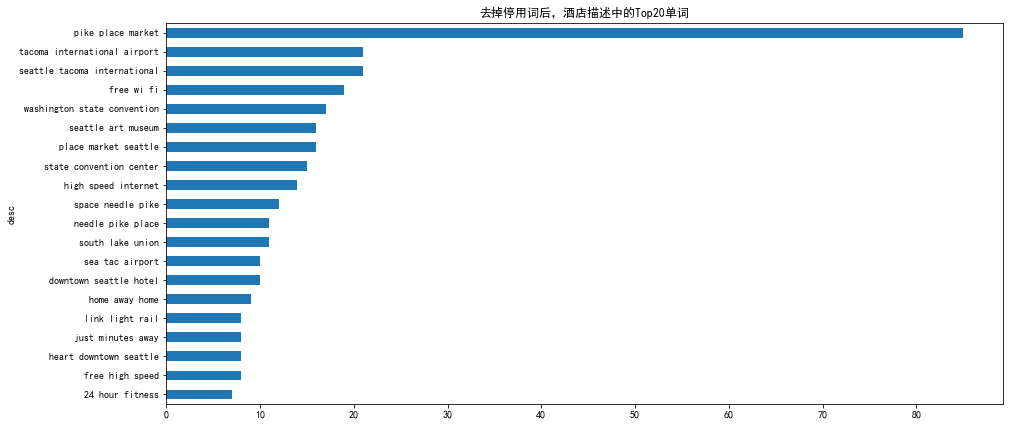

,desc,count
0,pike place market,85
1,seattle tacoma international,21
2,tacoma international airport,21
3,free wi fi,19
4,washington state convention,17


In [13]:
# 得到酒店描述中n-gram特征中的TopK个
def get_top_n_words(corpus, n=1, k=None):
    # 统计ngram词频矩阵
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    """
    print('feature names:')
    print(vec.get_feature_names())
    print('bag of words:')
    print(bag_of_words.toarray())
    """
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    # 按照词频从大到小排序
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:k]

common_words = get_top_n_words(df['desc'], 3, 20)
#print(common_words)
df1 = pd.DataFrame(common_words, columns = ['desc' , 'count'])
plt.figure(figsize=[15,7])
df1.groupby('desc').sum()['count'].sort_values().plot(kind='barh', title='去掉停用词后，酒店描述中的Top20单词')
plt.show()
df1.head()

In [16]:
# 文本预处理
import nltk
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
# 对文本进行清洗
def clean_text(text):
    # 全部小写
    text = text.lower()
    # 用空格替代一些特殊符号，如标点
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # 移除BAD_SYMBOLS_RE
    text = BAD_SYMBOLS_RE.sub('', text)
    # 从文本中去掉停用词
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

# 对desc字段进行清理
df['desc_clean'] = df['desc'].apply(clean_text)
#print(df['desc_clean'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# 建模
#if 'name' not in df.index:
#df.set_index('name', inplace = True)
# 使用TF-IDF提取文本特征
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words='english')

tfidf_matrix = tf.fit_transform(df['desc_clean'])
#print('TFIDF feature names:')
#print(tf.get_feature_names())
#print(len(tf.get_feature_names()))
#print('tfidf_matrix:')
#print(tfidf_matrix)
#print(tfidf_matrix.shape)
# 计算酒店之间的余弦相似度（线性核函数）
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
#print(cosine_similarities)
#print(cosine_similarities.shape)
indices = pd.Series(df.index) #df.index是酒店名称

In [56]:
# 基于相似度矩阵和指定的酒店name，推荐TOP10酒店
def recommendations(name, cosine_similarities = cosine_similarities):
    print('-'*60)
    recommended_hotels = []
    # 找到想要查询酒店名称的idx
    idx = indices[indices == name].index[0]
    #print('idx=', idx)
    # 对于idx酒店的余弦相似度向量按照从大到小进行排序
    score_series = pd.Series(cosine_similarities[idx]).sort_values(ascending = False)
    print('与',name,'相似的10家酒店：')
    # 取相似度最大的前10个（除了自己以外）
    top_10_indexes = list(score_series.iloc[0:11].index)
    # 放到推荐列表中
    for i in top_10_indexes:
        recommended_hotels.append(list(df.index)[i])
    hotels = pd.DataFrame(pd.Series(recommended_hotels), index=[i for i in range(1,11)],                               columns=['Name'])
    return hotels

print(recommendations('Hilton Seattle Airport & Conference Center'))
print(recommendations('The Bacon Mansion Bed and Breakfast'))
#print(result)

------------------------------------------------------------
与 Hilton Seattle Airport & Conference Center 相似的10家酒店：
                                                 Name
1   Embassy Suites by Hilton Seattle Tacoma Intern...
2          DoubleTree by Hilton Hotel Seattle Airport
3                            Seattle Airport Marriott
4               Motel 6 Seattle Sea-Tac Airport South
5                                 Knights Inn Tukwila
6     Four Points by Sheraton Downtown Seattle Center
7                      Radisson Hotel Seattle Airport
8                     Hampton Inn Seattle/Southcenter
9              Home2 Suites by Hilton Seattle Airport
10             Red Lion Hotel Seattle Airport Sea-Tac
------------------------------------------------------------
与 The Bacon Mansion Bed and Breakfast 相似的10家酒店：
                                      Name
1        11th Avenue Inn Bed and Breakfast
2   Shafer Baillie Mansion Bed & Breakfast
3                             Gaslight Inn
4        